## Setup and Data Exploration
---

In [51]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib, os
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set text displays for sklearn
from sklearn import set_config
set_config(display='text')
## Using pd.set_option to display more columns
pd.set_option('display.max_columns',50)

In [2]:
df_sales = pd.read_csv("Data/sales_predictions.csv")
df_sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
## Summarizing information on columns
def summarize_df(df_):
    df_sales = df_.copy()
    report = pd.DataFrame({
                        'dtype':df_sales.dtypes,
                        '# null': df_sales.isna().sum(),
                        'null (%)': df_sales.isna().sum()/len(df_sales)*100,
                        'nunique':df_sales.nunique(),
                        "min":df_sales.min(),
                        'max':df_sales.max()
             })
    report.index.name='Column'
    return report.reset_index()
summarize_df(df_sales)

C:\Users\josep\AppData\Local\Temp\ipykernel_11728\2986289318.py:9: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  "min":df_sales.min(),
C:\Users\josep\AppData\Local\Temp\ipykernel_11728\2986289318.py:10: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  'max':df_sales.max()


,Column,dtype,# null,null (%),nunique,min,max
0,Item_Fat_Content,object,0,0.000000,5,LF,reg
1,Item_Identifier,object,0,0.000000,1559,DRA12,NCZ54
2,Item_MRP,float64,0,0.000000,5938,31.29,266.8884
3,Item_Outlet_Sales,float64,0,0.000000,3493,33.29,13086.9648
4,Item_Type,object,0,0.000000,16,Baking Goods,Starchy Foods
5,Item_Visibility,float64,0,0.000000,7880,0.0,0.328391
6,Item_Weight,float64,1463,17.165317,415,4.555,21.35
7,Outlet_Establishment_Year,int64,0,0.000000,9,1985,2009
8,Outlet_Identifier,object,0,0.000000,10,OUT010,OUT049
9,Outlet_Location_Type,object,0,0.000000,3,Tier 1,Tier 3


## Data Cleaning
---

### Finding and Replacing bad Values

In [4]:
df_sales["Item_Fat_Content"].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [5]:
df_sales.replace(["LF", "reg", "low fat"], ["Low Fat", "Regular", "Low Fat"], inplace = True)
df_sales["Item_Fat_Content"].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

## Creating Preprocessor and Transforming Data
---

In [8]:
## Spliting the data and running the train test split
target = "Item_Outlet_Sales"
X = df_sales.drop(columns = ["Item_Outlet_Sales", "Item_Identifier", "Outlet_Identifier"]).copy()
y = df_sales[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
## Columns Selectors 
cat_selector = make_column_selector(dtype_include = "object")
num_selector = make_column_selector(dtype_include = "number")
cat_cols = cat_selector(X_train)
cat_cols

num_cols = num_selector(X_train)
num_cols

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [10]:
## Creating pipelines and column transformer 
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'),
                        )
preprocessor = make_column_transformer((cat_pipe,cat_cols),
                                        (num_pipe, num_cols), remainder='passthrough')

In [11]:
## Fitting
preprocessor.fit(X_train)

pd.DataFrame(preprocessor.transform(X_train).round(2))

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,16.35,0.03,256.46,2009.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,15.25,0.00,179.77,2009.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,12.35,0.16,157.29,1999.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,7.98,0.01,82.32,2004.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,19.35,0.02,120.91,2002.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,9.40,0.29,139.18,1998.0
6388,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,15.60,0.12,75.67,2007.0
6389,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,17.60,0.02,237.36,2002.0
6390,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,20.35,0.05,117.95,2007.0


In [12]:
## Finding correct step with ohe encoding
final_features = []
ohe_step = preprocessor.named_transformers_['pipeline-1'][-1]
ohe_step

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [13]:
## Getting columns names after transformation  
cat_features = ohe_step.get_feature_names_out(cat_cols)
cat_features

array(['Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Size_High', 'Outlet_Size_MISSING', 'Outlet_Size_Medium',
       'Outlet_Size_Small', 'Outlet_Location_Type_Tier 1',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3',
       'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3'],
      dtype=object)

In [14]:
## Adding numerical and categorical column names to list
## Use extend and not append to combine the two lists 
final_features.extend(cat_features)
final_features.extend(num_cols)
final_features

['Item_Fat_Content_Low Fat',
 'Item_Fat_Content_Regular',
 'Item_Type_Baking Goods',
 'Item_Type_Breads',
 'Item_Type_Breakfast',
 'Item_Type_Canned',
 'Item_Type_Dairy',
 'Item_Type_Frozen Foods',
 'Item_Type_Fruits and Vegetables',
 'Item_Type_Hard Drinks',
 'Item_Type_Health and Hygiene',
 'Item_Type_Household',
 'Item_Type_Meat',
 'Item_Type_Others',
 'Item_Type_Seafood',
 'Item_Type_Snack Foods',
 'Item_Type_Soft Drinks',
 'Item_Type_Starchy Foods',
 'Outlet_Size_High',
 'Outlet_Size_MISSING',
 'Outlet_Size_Medium',
 'Outlet_Size_Small',
 'Outlet_Location_Type_Tier 1',
 'Outlet_Location_Type_Tier 2',
 'Outlet_Location_Type_Tier 3',
 'Outlet_Type_Grocery Store',
 'Outlet_Type_Supermarket Type1',
 'Outlet_Type_Supermarket Type2',
 'Outlet_Type_Supermarket Type3',
 'Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year']

In [17]:
## Creating dataframes of X_train and X_test columns including the column names 
X_train_df = pd.DataFrame( preprocessor.transform(X_train), columns=final_features, index=X_train.index)
X_train_df.head()

,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,...,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
4776,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,16.350,0.029565,256.4646,2009.0
7510,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,15.250,0.000000,179.7660,2009.0
5828,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,12.350,0.158716,157.2946,1999.0
5327,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,7.975,0.014628,82.3250,2004.0
4810,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,19.350,0.016645,120.9098,2002.0


In [18]:
## Creating dataframes of X_train and X_test columns including the column names 
X_test_df = pd.DataFrame(preprocessor.transform(X_test), columns=final_features, index=X_test.index)
X_test_df.head()

,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,...,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
7503,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,14.300000,0.026300,79.4302,1987.0
2957,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,7.930000,0.071136,42.7086,1997.0
7031,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,14.500000,0.041313,42.0454,1999.0
1084,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,12.904458,0.044767,173.7054,1985.0
856,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,10.195000,0.012456,197.5110,2004.0


In [20]:
## Adding constant to X_train/test dataframes in order to calculate the coefficient
## Overwrite 
X_train_df = sm.add_constant(X_train_df,has_constant='add', prepend=False)
X_test_df = sm.add_constant(X_test_df,has_constant='add', prepend=False)
display(X_train_df.head(5), X_test_df.head(5))

,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,...,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,const
4776,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,16.350,0.029565,256.4646,2009.0,1.0
7510,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,15.250,0.000000,179.7660,2009.0,1.0
5828,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,12.350,0.158716,157.2946,1999.0,1.0
5327,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,7.975,0.014628,82.3250,2004.0,1.0
4810,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,19.350,0.016645,120.9098,2002.0,1.0


,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,...,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,const
7503,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,14.300000,0.026300,79.4302,1987.0,1.0
2957,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,7.930000,0.071136,42.7086,1997.0,1.0
7031,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,14.500000,0.041313,42.0454,1999.0,1.0
1084,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,12.904458,0.044767,173.7054,1985.0,1.0
856,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,10.195000,0.012456,197.5110,2004.0,1.0


## Linear Regression Model
---

In [34]:
## Function to print out Regression Model Metrics
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

In [36]:
## Creating Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Split,R^2,MAE,RMSE
Train,0.56,847.13,"1,139.10"
Test,0.57,804.12,"1,092.86"


In [37]:
## Accessing Coefficients
coef = lin_reg.coef_
coef

array([-3.13126168e+01,  3.13126168e+01, -1.86125405e+01, -4.72608587e+01,
        2.67485232e+01,  8.90365370e+00, -1.24947555e+02, -2.03831667e+01,
        2.71414890e+01, -4.71764142e+00,  8.41287319e+00, -1.31027942e+01,
       -3.04774272e+01, -4.54262663e+01,  3.08888596e+02, -4.05449331e+01,
       -5.80982758e+01,  2.34763241e+01,  4.95897145e+02, -2.74294088e+02,
       -8.33530059e+01, -1.38250052e+02,  1.04751265e+02,  5.35796799e+01,
       -1.58330945e+02, -1.55826505e+03, -2.40060062e+01, -4.02580314e+02,
        1.98485137e+03, -1.94181707e+00, -4.23390180e+02,  1.57209242e+01,
        2.83096799e+01,  0.00000000e+00])

In [38]:
## Accessing Intercept
intercept = lin_reg.intercept_
intercept

-56362.45236596206

In [42]:
## Saving the coefficients
def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs
coeffs

Item_Fat_Content_Low Fat             -31.312617
Item_Fat_Content_Regular              31.312617
Item_Type_Baking Goods               -18.612541
Item_Type_Breads                     -47.260859
Item_Type_Breakfast                   26.748523
Item_Type_Canned                       8.903654
Item_Type_Dairy                     -124.947555
Item_Type_Frozen Foods               -20.383167
Item_Type_Fruits and Vegetables       27.141489
Item_Type_Hard Drinks                 -4.717641
Item_Type_Health and Hygiene           8.412873
Item_Type_Household                  -13.102794
Item_Type_Meat                       -30.477427
Item_Type_Others                     -45.426266
Item_Type_Seafood                    308.888596
Item_Type_Snack Foods                -40.544933
Item_Type_Soft Drinks                -58.098276
Item_Type_Starchy Foods               23.476324
Outlet_Size_High                     495.897145
Outlet_Size_MISSING                 -274.294088
Outlet_Size_Medium                   -83

In [ ]:
## formatting numbers to not use , thousands sep, and 4 digits floats
pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option('display.max_rows', None)

In [43]:
## Sorting Coefficients
coeffs.sort_values()

intercept                         -56362.452366
Outlet_Type_Grocery Store          -1558.265050
Item_Visibility                     -423.390180
Outlet_Type_Supermarket Type2       -402.580314
Outlet_Size_MISSING                 -274.294088
Outlet_Location_Type_Tier 3         -158.330945
Outlet_Size_Small                   -138.250052
Item_Type_Dairy                     -124.947555
Outlet_Size_Medium                   -83.353006
Item_Type_Soft Drinks                -58.098276
Item_Type_Breads                     -47.260859
Item_Type_Others                     -45.426266
Item_Type_Snack Foods                -40.544933
Item_Fat_Content_Low Fat             -31.312617
Item_Type_Meat                       -30.477427
Outlet_Type_Supermarket Type1        -24.006006
Item_Type_Frozen Foods               -20.383167
Item_Type_Baking Goods               -18.612541
Item_Type_Household                  -13.102794
Item_Type_Hard Drinks                 -4.717641
Item_Weight                           -1

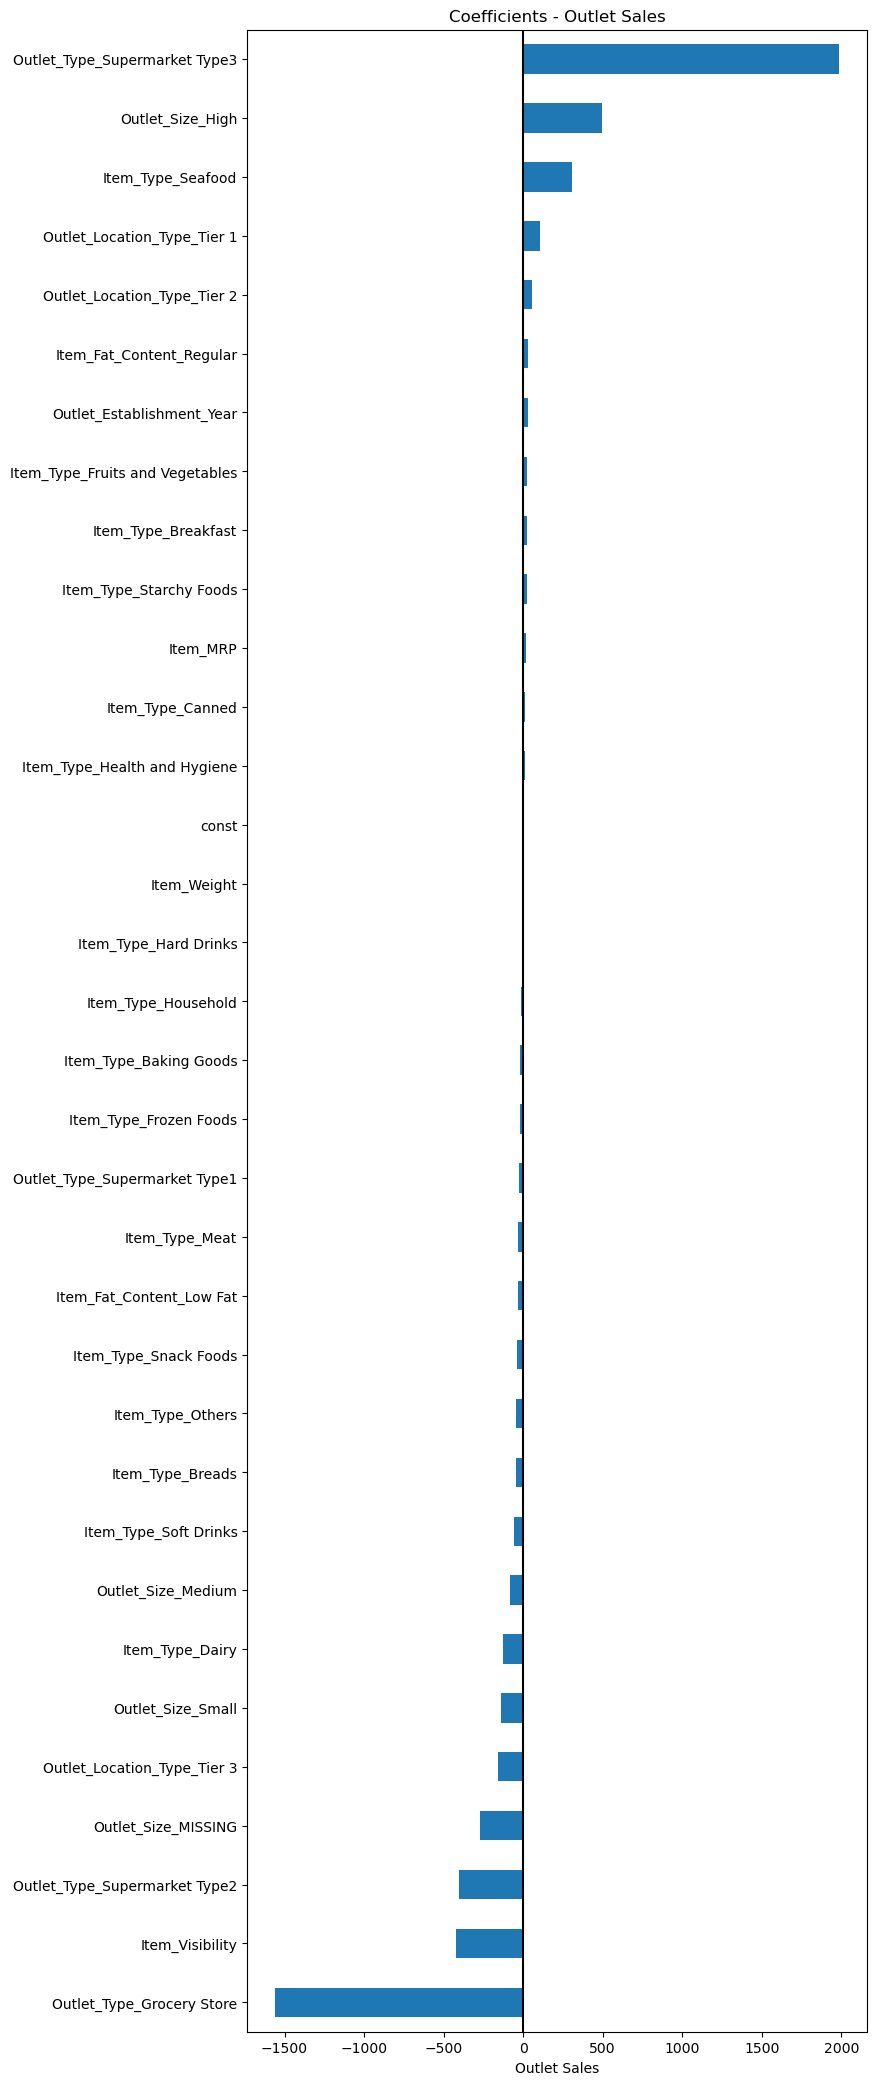

In [48]:
## Plot ceoffs
ax = coeffs.drop("intercept").sort_values().plot(kind='barh', figsize=(8,26))
ax.axvline(0, color='k')
ax.set(xlabel='Outlet Sales', title="Coefficients - Outlet Sales");

### Top Three Features for Linear Regression Model for Determining Price
---
1. Outlet Type is the most important feature if the outlet type = grocery store it has a -1500 impact on the outlet sales.
2. Outlet Size is the second most important feature, those with a High size receiving 500+ to their total sales.
3. Item Visibility is the third most important feature with a negative coefficient of of almost 500.

## Creating Random Forest Model
---

In [46]:
## Creating RF Model
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
evaluate_regression(rf_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.94,298.48,429.14
Test,0.55,772.35,"1,110.68"


In [49]:
## Saving the coefficients
def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances

importances = get_importances(rf_reg)
importances

Item_Fat_Content_Low Fat           0.005682
Item_Fat_Content_Regular           0.004869
Item_Type_Baking Goods             0.004167
Item_Type_Breads                   0.002564
Item_Type_Breakfast                0.002917
Item_Type_Canned                   0.004313
Item_Type_Dairy                    0.006554
Item_Type_Frozen Foods             0.005873
Item_Type_Fruits and Vegetables    0.007685
Item_Type_Hard Drinks              0.002985
Item_Type_Health and Hygiene       0.003878
Item_Type_Household                0.006309
Item_Type_Meat                     0.003687
Item_Type_Others                   0.001643
Item_Type_Seafood                  0.001711
Item_Type_Snack Foods              0.008355
Item_Type_Soft Drinks              0.005759
Item_Type_Starchy Foods            0.003444
Outlet_Size_High                   0.002442
Outlet_Size_MISSING                0.004519
Outlet_Size_Medium                 0.004405
Outlet_Size_Small                  0.006614
Outlet_Location_Type_Tier 1     

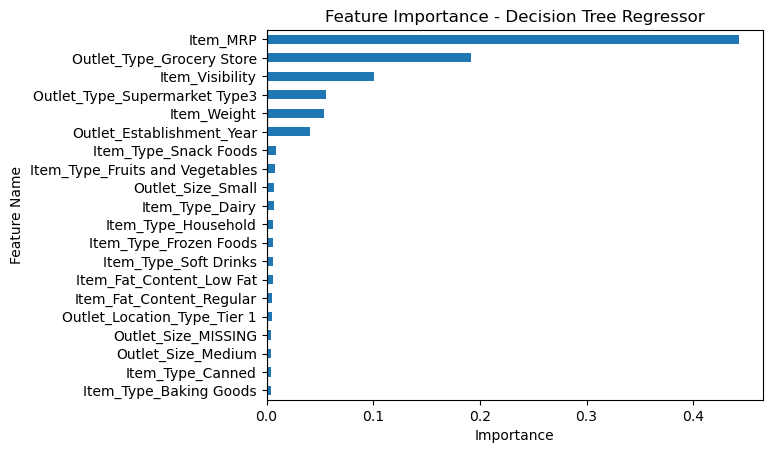

In [50]:
ax = importances.sort_values().tail(20).plot(kind='barh')#,figsize=(6,4))
ax.axvline(0, color='k')
ax.set(title='Feature Importance - Decision Tree Regressor',ylabel="Feature Name",
      xlabel='Importance');

### Top Three Features for Determing Sales Total with a Random Forest Model
---
1. Item MRP accounted for roughly 40% of the total sales determination. 
2. Outlet Type = grocery store accounted slightly more than 20% of the final total sales.
3. Item visibility accounted for slightly more than 10% of the final total sales.

## Saving Models
---

In [56]:
## Mapping for joblib
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train,
         'y_train':y_train,
         'X_test':X_test,
         'y_test':y_test,
          'preprocessor': preprocessor,
         'LinearRegression': lin_reg,
          'RandomForestRegressor':rf_reg
         }
folder = "Models/"

In [57]:
## Creating file 
fname = folder+'Project-One_Models.joblib'
joblib.dump(export, fname)

['Models/Project-One_Models.joblib']